In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
from IPython.core.display import display, HTML
from cross_validation import *
from build_polynomial import *
%load_ext autoreload
%autoreload 2
from proj1_helpers import *
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))


## Load the training data into feature matrix, class labels, and event ids:

In [72]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
#y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
#print(y.shape, tX.shape, ids.shape)

In [ ]:
import pandas as pd
df = pd.read_csv("../data/train.csv")
df.tail()

In [48]:
y0, tX0, id0 = load_data_jet_number(DATA_TRAIN_PATH, 0)
y1, tX1, id1 = load_data_jet_number(DATA_TRAIN_PATH, 1)
y2, tX2, id2 = load_data_jet_number(DATA_TRAIN_PATH, 2)
y3, tX3, id3 = load_data_jet_number(DATA_TRAIN_PATH, 3)
tX0_standardized, tX0_mean, tX0_std= standardize(tX0)
tX1_standardized, tX1_mean, tX1_std= standardize(tX1)
tX2_standardized, tX2_mean, tX2_std= standardize(tX2)
tX3_standardized, tX3_mean, tX3_std= standardize(tX3)

## Do your thing crazy machine learning thing here :) ...

In [50]:
tX0_standardized = np.c_[np.ones((y0.shape[0], 1)), tX0_standardized] #VERY IMPORTANT
y0=y0.reshape(-1,1)
y0=(y0+1)/2
tX1_standardized = np.c_[np.ones((y1.shape[0], 1)), tX1_standardized] #VERY IMPORTANT
y1=y1.reshape(-1,1)
y1=(y1+1)/2
tX2_standardized = np.c_[np.ones((y2.shape[0], 1)), tX2_standardized] #VERY IMPORTANT
y2=y2.reshape(-1,1)
y2=(y2+1)/2
tX3_standardized = np.c_[np.ones((y3.shape[0], 1)), tX3_standardized] #VERY IMPORTANT
y3=y3.reshape(-1,1)
y3=(y3+1)/2

DEGREE = 1
Lambda = 1e-08
Lambda = 2.6366508987303555e-08
Lambda = 6.951927961775605e-08
Lambda = 1.8329807108324375e-07
Lambda = 4.832930238571752e-07
Lambda = 1.2742749857031322e-06
Lambda = 3.359818286283781e-06
Lambda = 8.858667904100832e-06
Lambda = 2.3357214690901213e-05
Lambda = 6.158482110660255e-05
Lambda = 0.0001623776739188721
Lambda = 0.00042813323987193956
Lambda = 0.0011288378916846883
Lambda = 0.002976351441631313
Lambda = 0.007847599703514606
Lambda = 0.0206913808111479
Lambda = 0.05455594781168514
Lambda = 0.143844988828766
Lambda = 0.3792690190732246
Lambda = 1.0


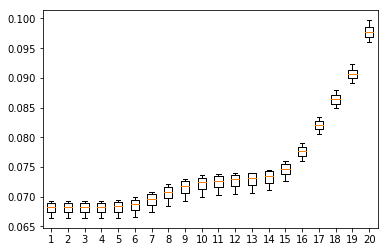

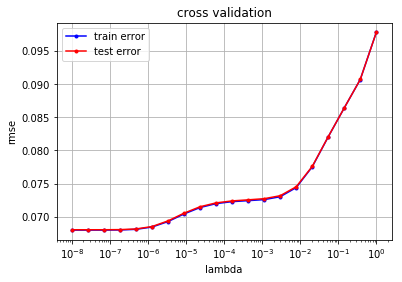

Test best error = 0.06804808302025053for lambda = 1e-08
DEGREE = 2
Lambda = 1e-08
Lambda = 2.6366508987303555e-08
Lambda = 6.951927961775605e-08
Lambda = 1.8329807108324375e-07
Lambda = 4.832930238571752e-07
Lambda = 1.2742749857031322e-06
Lambda = 3.359818286283781e-06
Lambda = 8.858667904100832e-06
Lambda = 2.3357214690901213e-05
Lambda = 6.158482110660255e-05
Lambda = 0.0001623776739188721
Lambda = 0.00042813323987193956
Lambda = 0.0011288378916846883
Lambda = 0.002976351441631313
Lambda = 0.007847599703514606
Lambda = 0.0206913808111479
Lambda = 0.05455594781168514
Lambda = 0.143844988828766
Lambda = 0.3792690190732246
Lambda = 1.0


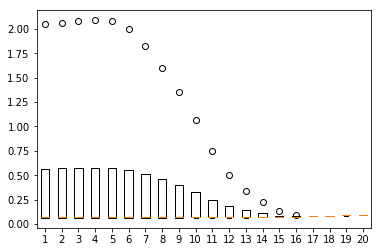

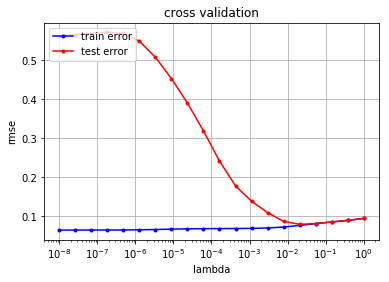

Test best error = 0.07874914005411365for lambda = 0.0206913808111479
DEGREE = 3
Lambda = 1e-08
Lambda = 2.6366508987303555e-08
Lambda = 6.951927961775605e-08
Lambda = 1.8329807108324375e-07
Lambda = 4.832930238571752e-07
Lambda = 1.2742749857031322e-06
Lambda = 3.359818286283781e-06
Lambda = 8.858667904100832e-06
Lambda = 2.3357214690901213e-05
Lambda = 6.158482110660255e-05
Lambda = 0.0001623776739188721
Lambda = 0.00042813323987193956
Lambda = 0.0011288378916846883
Lambda = 0.002976351441631313
Lambda = 0.007847599703514606
Lambda = 0.0206913808111479
Lambda = 0.05455594781168514
Lambda = 0.143844988828766
Lambda = 0.3792690190732246
Lambda = 1.0


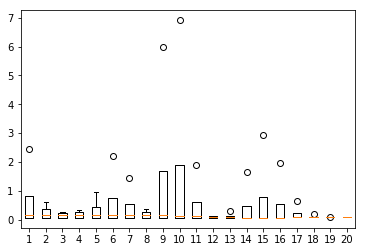

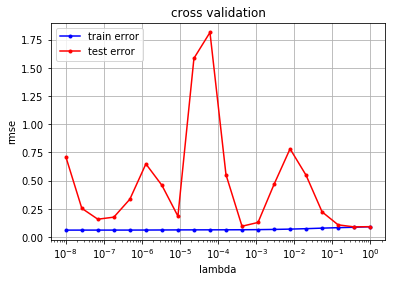

Test best error = 0.09080038532748466for lambda = 0.3792690190732246
DEGREE = 4
Lambda = 1e-08
Lambda = 2.6366508987303555e-08
Lambda = 6.951927961775605e-08
Lambda = 1.8329807108324375e-07
Lambda = 4.832930238571752e-07
Lambda = 1.2742749857031322e-06
Lambda = 3.359818286283781e-06
Lambda = 8.858667904100832e-06
Lambda = 2.3357214690901213e-05
Lambda = 6.158482110660255e-05
Lambda = 0.0001623776739188721
Lambda = 0.00042813323987193956
Lambda = 0.0011288378916846883
Lambda = 0.002976351441631313
Lambda = 0.007847599703514606
Lambda = 0.0206913808111479
Lambda = 0.05455594781168514
Lambda = 0.143844988828766
Lambda = 0.3792690190732246
Lambda = 1.0


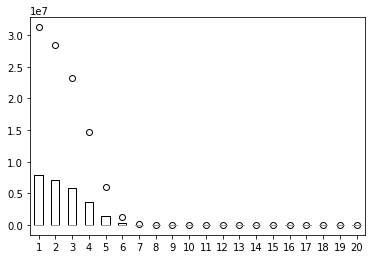

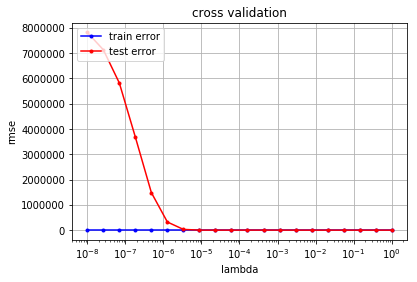

Test best error = 0.35096482764211295for lambda = 1.0
Test best error = 0.06804808302025053for lambda = 1e-08and degree = 1


In [45]:
weights_0, loss_0, deg0 = cross_validation_best_weight(y0, tX0_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet0")


In [46]:
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

def calculate_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    pred = sigmoid(tx.dot(w))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    return np.squeeze(- loss)

def calculate_gradient(y, tx, w):
    """compute the gradient of loss."""
    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y)
    return grad

def penalized_logistic_regression(y, tx, w, lambda_):
    """return the loss and gradient."""
    num_samples = y.shape[0]
    loss_cal=calculate_loss(y, tx, w)
    loss = loss_cal + lambda_ * np.squeeze(w.T.dot(w))
    grad=calculate_gradient(y, tx, w)
    gradient = grad + 2 * lambda_ * w
    
    
    return loss, gradient

def learning_by_penalized_gradient(y, tx, w, gamma, lambda_):
    """
    Do one step of gradient descent, using the penalized logistic regression.
    Return the loss and updated w.
    """
    loss, gradient = penalized_logistic_regression(y, tx, w, lambda_)
    w -= gamma * gradient
    return loss, w

In [54]:
    # init parameters
    max_iter = 10000
    gamma = 0.00002
    lambda_ = 0
    threshold = 1e-1
    losses0 = []
    losses1 = []
    losses2 = []
    losses3 = []

    # build tx
    w0 = np.ones((tX0_standardized.shape[1], 1))/100
    w1 = np.ones((tX1_standardized.shape[1], 1))/100
    w2 = np.ones((tX2_standardized.shape[1], 1))/100
    w3 = np.ones((tX3_standardized.shape[1], 1))/100
    
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w0 = learning_by_penalized_gradient(y0, tX0_standardized, w0, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss), end="")
            if iter != 0 : 
                print("rate = " + str(losses0[-2]-losses0[-1]))
            print("")
        # converge criterion
        losses0.append(loss)
        if len(losses0) > 1 and np.abs(losses0[-1] - losses0[-2]) < threshold:
            break
            
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w1 = learning_by_penalized_gradient(y1, tX1_standardized, w1, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss), end="")
            if iter != 0 : 
                print("rate = " + str(losses1[-2]-losses1[-1]))
            print("")
        # converge criterion
        losses1.append(loss)
        if len(losses1) > 1 and np.abs(losses1[-1] - losses1[-2]) < threshold:
            break
            
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w2 = learning_by_penalized_gradient(y2, tX2_standardized, w2, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss), end="")
            if iter != 0 : 
                print("rate = " + str(losses2[-2]-losses2[-1]))
            print("")
        # converge criterion
        losses2.append(loss)
        if len(losses2) > 1 and np.abs(losses2[-1] - losses2[-2]) < threshold:
            break
            
    # start the logistic regression
    for iter in range(max_iter):
        # get loss and update w.
        loss, w3 = learning_by_penalized_gradient(y3, tX3_standardized, w3, gamma, lambda_)
        # log info
        if iter % 100 == 0:
            print("Current iteration={i}, loss={l}".format(i=iter, l=loss), end="")
            if iter != 0 : 
                print("rate = " + str(losses3[-2]-losses3[-1]))
            print("")
        # converge criterion
        losses3.append(loss)
        if len(losses3) > 1 and np.abs(losses3[-1] - losses3[-2]) < threshold:
            break
    # visualization
    #visualization(y, x, mean_x, std_x, w, "classification_by_logistic_regression_penalized_gradient_descent")

Current iteration=0, loss=69106.55092803156
Current iteration=100, loss=44698.8507354821rate = 0.18633563091862015

Current iteration=200, loss=43839.7720756324rate = 0.18633563091862015

Current iteration=300, loss=43566.268381367074rate = 0.18633563091862015

Current iteration=400, loss=43438.47765898645rate = 0.18633563091862015

Current iteration=500, loss=43370.20071606392rate = 0.18633563091862015

Current iteration=600, loss=43331.44578466732rate = 0.18633563091862015

Current iteration=700, loss=43308.525770761284rate = 0.18633563091862015

Current iteration=800, loss=43294.448166960865rate = 0.18633563091862015

Current iteration=0, loss=53499.17823036599
Current iteration=100, loss=65265.685398635505rate = 0.18633563091862015

Current iteration=200, loss=62568.00693197032rate = 0.18633563091862015

Current iteration=300, loss=61466.59086624314rate = 0.18633563091862015

Current iteration=400, loss=60935.487483998455rate = 0.18633563091862015

Current iteration=500, loss=60643

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Current iteration=100, loss=34984.26832743939rate = -3821.6067855798537

Current iteration=200, loss=33672.36694440196rate = -2968.4620030867954

Current iteration=300, loss=33107.952908649044rate = -2602.1979998644892

Current iteration=400, loss=32834.5431400089rate = -2431.3543523783155

Current iteration=500, loss=32684.0556713318rate = -2341.821669017416

Current iteration=600, loss=32591.58690903614rate = -2289.258202501893

Current iteration=700, loss=32529.32405126687rate = -2255.098797579347

Current iteration=800, loss=32484.202276334472rate = -2230.9255485963513

Current iteration=900, loss=32449.602181454175rate = -2212.630512960317

Current iteration=1000, loss=32421.93884474264rate = -2198.0684864720242

Current iteration=1100, loss=32399.14416968828rate = -2186.045445776279

Current iteration=1200, loss=32379.949334905163rate = -2175.855151911608

Current iteration=1300, loss=32363.52862832066rate = -2167.055065005592

Current iteration=1400, loss=32349.31490674425rate =

In [44]:
#lambda_=0.0000001
k_fold=4
seed=5
degree=5 #will -1 as range exclude last elem
lower_lambda=-8
upper_lambda=0

weights_0, loss_0, deg0 = cross_validation_best_weight(y0, tX0_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet0")
weights_1, loss_1, deg1 = cross_validation_best_weight(y1, tX1_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet1")
weights_2, loss_2, deg2 = cross_validation_best_weight(y2, tX2_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet2")
weights_3, loss_3, deg3 = cross_validation_best_weight(y3, tX3_standardized,k_fold,degree,seed,lower_lambda,upper_lambda,"jet3")

DEGREE = 1
Lambda = 1e-08
Lambda = 2.6366508987303555e-08
Lambda = 6.951927961775605e-08
Lambda = 1.8329807108324375e-07
Lambda = 4.832930238571752e-07


KeyboardInterrupt: 

In [60]:
print(w0)
print(w1)
print(w2)
print(w3)

[[-0.61695658]
 [ 0.14857064]
 [-3.82837348]
 [-2.17865672]
 [-0.69352154]
 [ 0.35816054]
 [-0.69352167]
 [ 2.7326339 ]
 [-0.09554964]
 [ 0.27717848]
 [ 3.78119297]
 [ 0.11449057]
 [ 0.06062412]
 [-0.95666231]
 [ 0.13556019]
 [ 0.12773408]
 [ 0.01362808]
 [ 0.02666262]
 [ 0.20937149]]
[[ 1.54618678]
 [ 0.31934659]
 [-3.05133501]
 [-0.95803082]
 [-1.17022105]
 [ 4.33981332]
 [ 0.96363686]
 [ 2.4051632 ]
 [-1.89431258]
 [ 7.99324038]
 [ 2.39082933]
 [-0.49993661]
 [-1.09313215]
 [-0.56065293]
 [-0.97698709]
 [-0.42442662]
 [ 2.12551547]
 [-0.11533563]
 [ 0.03116157]
 [-0.64414023]
 [-0.56763915]
 [-0.69290636]
 [-0.64412485]]
[[ 0.40011383]
 [ 0.1655617 ]
 [-2.75067513]
 [-0.54386581]
 [ 0.22362322]
 [-0.77059985]
 [ 0.41479672]
 [ 1.20924516]
 [ 1.50963366]
 [-0.67119957]
 [ 1.533982  ]
 [-0.93294492]
 [ 2.77409202]
 [ 1.14650287]
 [ 2.38723362]
 [-0.3230862 ]
 [-0.3413952 ]
 [ 0.20880044]
 [-0.40042485]
 [ 0.03177699]
 [ 1.96036339]
 [ 0.15105644]
 [-0.90277407]
 [-1.74601854]
 [ 0.072

# Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
print(tX_test.shape, ids_test.shape)

In [61]:
weights_0=w0
weights_1=w1
weights_2=w2
weights_3=w3

In [63]:
_, tX0_te, id0_te = load_data_jet_number("../data/test.csv", 0)
_, tX1_te, id1_te = load_data_jet_number("../data/test.csv", 1)
_, tX2_te, id2_te = load_data_jet_number("../data/test.csv", 2)
_, tX3_te, id3_te = load_data_jet_number("../data/test.csv", 3)
tX0_te_standardized, tX0_te_mean, tX0_te_std= standardize(tX0_te)
tX1_te_standardized, tX1_te_mean, tX1_te_std= standardize(tX1_te)
tX2_te_standardized, tX2_te_mean, tX2_te_std= standardize(tX2_te)
tX3_te_standardized, tX3_te_mean, tX3_te_std= standardize(tX3_te)

In [68]:
tX0_te_standardized=np.c_[np.ones((tX0_te_standardized.shape[0], 1)), tX0_te_standardized]
tX1_te_standardized=np.c_[np.ones((tX1_te_standardized.shape[0], 1)), tX1_te_standardized]
tX2_te_standardized=np.c_[np.ones((tX2_te_standardized.shape[0], 1)), tX2_te_standardized]
tX3_te_standardized=np.c_[np.ones((tX3_te_standardized.shape[0], 1)), tX3_te_standardized]

In [69]:
OUTPUT_PATH = '../data/pred.csv' # TODO: fill in desired name of output file for submission
y0_pred = predict_labels(weights_0, tX0_te_standardized)
y1_pred = predict_labels(weights_1, tX1_te_standardized)
y2_pred = predict_labels(weights_2, tX2_te_standardized)
y3_pred = predict_labels(weights_3, tX3_te_standardized)

In [70]:
y_pred_all=np.concatenate([y0_pred,y1_pred,y2_pred,y3_pred])
ids_pred_all=np.concatenate([id0_te,id1_te,id2_te,id3_te])
y_and_ids=list(zip(*sorted(zip(ids_pred_all, y_pred_all))))
ids_test=y_and_ids[0]
y_pred=y_and_ids[1]

In [71]:
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)